In [96]:
#qiskitQIMP\Scripts\activate.bat

import qiskit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matpltimg

from skimage.transform import resize

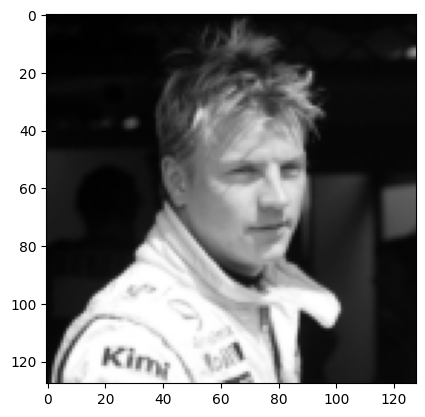

In [97]:
#Import + Processing
filename = 'kimi.jpg'
image = matpltimg.imread(filename)

# Resize the image
n_qubits = 15 # an even number, since image is square
n_pixels_per_side = 2**int(n_qubits/2)
image = resize(image, (n_pixels_per_side, n_pixels_per_side))

image = 0.299*image[:,:,0]+0.586*image[:,:,1]+0.144*image[:,:,2]

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

In [98]:
#Initialize into quantum state

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Flatten red channel to a 1D array
data = image.ravel()
data = data/np.linalg.norm(data) #Normalizes so probability is 1

qc = QuantumCircuit(n_qubits)

# Initialize circuit to statevector
qc.initialize(data, qc.qubits)


QiskitError: 'StatePreparation parameter vector has 16384 elements, therefore expects 14 qubits. However, 15 were provided.'

In [ ]:
#Add Circuit

qc.h(0)

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import transpile


qc.save_statevector()

sim = AerSimulator()
qc_t = transpile(qc, sim)
result = sim.run(qc_t).result()

# Get final statevector
final_state = result.get_statevector()

# Display result
print("Final statevector:\n", final_state)

QiskitError: 'No statevector for experiment "None"'